# Forex Backtesting Using The Relative Strength Indicator (2)

---
This notebook explores the use of the **2 period relative strength indicator** as a component of a trading strategy, applied to historical forex data.The focus is on **GBP/USD** currency pair (British Pound Sterling against the United States Dollar).

## Objective

To evaluate the performance of a Relative Strength Index-based trading strategy through backtesting - measuring how a trading account's capital would have changed over time based on historical price data.

## Dataset Details
1. **Currency Pair:** GBP/USD
2. **Timeframe:** daily (1D)
3. **Source:** Yahoo Finance
4. **Time Range:** 2000-01-01 to 2024-12-31

In [2]:
# Downloading data from yahoo finance
import yfinance as yf

df = yf.download('GBPUSD=X',start='2005-01-01',end='2025-01-01',interval='1D',auto_adjust=False)
df.columns = df.columns.get_level_values(0) # Flatten MultiIndex columns
df.reset_index(inplace=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
5196,2024-12-25,1.253604,1.253604,1.281306,1.241000,1.253604,0
5197,2024-12-26,1.254375,1.254375,1.255000,1.250266,1.254390,0
5198,2024-12-27,1.252976,1.252976,1.259145,1.250672,1.252944,0
5199,2024-12-30,1.257881,1.257881,1.260748,1.250813,1.257957,0
5200,2024-12-31,1.254910,1.254910,1.256818,1.251486,1.254900,0


## Python Libraries
---
This notebook uses the following Python libraries:
1.**YFinance** (for downloading historical data)
2. **Pandas** (for data manipulation)
3. **Numpy** (for numerical ooperations)
4. **Matplotlib** (for visualization)
5. **TA** (for technical analysis indicators)

## Trading Indicators
---
The trading strategy implemented in this notebook uses the following indicators:
1. **Relative Strength Index** (period = 2)
2. **Simple Moving Average** (period = 100)
3. **Simple Moving Average** (period = 50)
4. **Average True Range** (period = 14)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
import ta

#--------------------------------------
# Inserting Indicators to the DataFrame
#--------------------------------------
# Moving Averages to determine the bias
df['slow_MA']= df['Close'].rolling(window=100).mean()

# Inserting the ATR
atr=ta.volatility.AverageTrueRange(high=df['High'],low=df['Low'],close=df['Close'],window=14)
df['atr']=atr.average_true_range()

#Inserting the RSI
rsi=ta.momentum.RSIIndicator(close=df['Close'],window=2)
df['RSI']=rsi.rsi()

print('**Completed**')

**Completed**


## Entry Criteria
---
A **BUY** signal is generated when all of the following conditions are met:
1. Price closes below the lower threshold of the (2)RSI taken as the 40 level
2. Then, price closes back above the lower threshold
3. The current price is above the 100-period simple moving average (indicating a bullish trend)

A **SELL** signal is generated when all of the following conditions are met:
1. Price closes above the upper threshold of the (2)RSI taken as the 60 level
2. Then, price closes back below the upper threshold
3. The current price is below the 100-period simple moving average (indicating a bearish trend)

## Exit Criteria
---
1. The position is set to close when the price hits the stop loss order,
2. The position also closes when price hits a profit target order

## Risk Management
---
1. A stop loss order is set at 2x ATR from the entry price
2. A profit target order is set at 2x the stop loss order
3. The amount risked per trade is 1 % of the starting account balance for all trades
   

In [4]:
#--------------------------------------------
# Extracting Trade details from the Dataframe
#--------------------------------------------
def RSI_trades(df):
    n=len(df)-1
    trades=[]
    atr_multiple=2
    upper_threshold=60
    lower_threshold=40
    for i in range(n):
        # Bullish trades
        if (df.iloc[i]['RSI'] < lower_threshold
            and df.iloc[i+1]['RSI'] > lower_threshold
            and df.iloc[i+1]['Close'] >= df.iloc[i+1]['slow_MA']
           ): 
            trades.append({'date_formed':df.iloc[i+1]['Date'],
                           'entry':df.iloc[i+1]['Close'],
                           'SL':df.iloc[i+1]['Close']-(atr_multiple*df.iloc[i+1]['atr']),
                           'Pips':round(10000*(atr_multiple*df.iloc[i+1]['atr']),1),
                           'type':'bullish'})
        # Bearish trades
        elif (df.iloc[i]['RSI'] > upper_threshold
              and df.iloc[i+1]['RSI'] < upper_threshold
              and df.iloc[i+1]['Close'] <= df.iloc[i+1]['slow_MA']
             ):
            trades.append({'date_formed':df.iloc[i+1]['Date'],
                           'entry':df.iloc[i+1]['Close'],
                           'SL':df.iloc[i+1]['Close']+(atr_multiple*df.iloc[i+1]['atr']),
                           'Pips':round(10000*(atr_multiple*df.iloc[i+1]['atr']),1),
                           'type':'bearish'})
    detected_trades=pd.DataFrame(trades)
    dtrades_sorted=detected_trades.sort_values(by=['date_formed'],ascending=True)
    dtrades=dtrades_sorted.reset_index(drop=True)
    return dtrades

dtrades=RSI_trades(df)

# Confirming that the SL is set appropriately
def Gaurd(trades):
    # Bullish SL Check
    bullish_mask = (trades['type'] == 'bullish') & (trades['entry'] < trades['SL'])
    if bullish_mask.any():
        idx = trades[bullish_mask].index[0]
        raise ValueError(f'Bullish SL Error at index {idx}')
    
    # Bearish SL Check
    bearish_mask = (trades['type'] == 'bearish') & (trades['entry'] > trades['SL'])
    if bearish_mask.any():
        idx = trades[bearish_mask].index[0]
        raise ValueError(f'Bearish SL Error at index {idx}')
    
    return trades

entries = Gaurd(dtrades)
entries

,date_formed,entry,SL,Pips,type
0,2005-05-26,1.820399,1.843756,233.6,bearish
1,2005-06-08,1.824385,1.848075,236.9,bearish
2,2005-06-20,1.822589,1.846897,243.1,bearish
3,2005-06-22,1.820897,1.845653,247.6,bearish
4,2005-06-28,1.817191,1.841103,239.1,bearish
...,...,...,...,...,...
768,2024-11-21,1.265534,1.286539,210.1,bearish
769,2024-12-03,1.265855,1.286799,209.4,bearish
770,2024-12-12,1.276634,1.295903,192.7,bearish
771,2024-12-19,1.256771,1.276875,201.0,bearish


# Backtest Logic
---

## *Assumptions Made in Backtesting*

1. **Historical data is accurate and representative:**  
   Prices, volumes, and spreads in the past are assumed to reflect reality.

2. **No slippage or transaction costs:**  
   Real trades often incur fees (including swap and spread) and prices may move during execution.

3. **Signals are executed immediately:**  
   The strategy assumes you can act on signals at the close of the candle.

4.  **Percentage risk is always calculated from the starting balance.**
  
5.  **Starting balance is assumed as $10,000.**

In [11]:
#----------------
# BACKTEST LOGIC
#----------------
def Backtest(df,entry_dataframe,Risk,RRR):
    trades = []
    Starting_balance=10000
    running_balance=[Starting_balance]

    for i in range(len(entry_dataframe)):
        entry = entry_dataframe.iloc[i]['entry']
        SL = entry_dataframe.iloc[i]['SL']
        direction = entry_dataframe.iloc[i]['type']
        entry_date = entry_dataframe.iloc[i]['date_formed']
        
        TP = entry + (RRR * (entry - SL))  # Bullish TP target; to be adjusted for bearish
        
        # Find the matching index in df for the entry point
        entry_index = df[(df['Date'] == entry_date)].index

        if not entry_index.empty:
            j = entry_index[0] + 1  # Start checking after the signal

            while j < len(df):
                current_price1 = df.iloc[j]['High']
                current_price2 = df.iloc[j]['Low']
                current_balance=running_balance[-1]
                risk_amount=(Risk/100)*Starting_balance
                profit_amount=RRR*(Risk/100)*Starting_balance
                maxvalue=max(running_balance)
                
                #=========================
                if direction == 'bullish':
                    if current_price1 >= TP:
                        current_balance+=profit_amount
                        drawdown=((maxvalue-current_balance)/maxvalue)*100
                        if drawdown<0: drawdown=0
                        running_balance.append(current_balance)
                        trades.append({
                            'Trade': 'buy',
                            'Entry date':entry_date,
                            'Result': 'Win',
                            'Risk Amount':round(risk_amount,2),
                            'Profit Amount':round(profit_amount,2),
                            'PnL':round(profit_amount,2),
                            'Entry': entry,
                            'SL': SL,
                            'TP': TP,
                            'Final balance':round(current_balance,2),
                            'Returns':round((100*(current_balance-running_balance[-2])/running_balance[-2]),2),
                            'Drawdown %':round(drawdown,2)
                        })
                        break
                    elif current_price2 <= SL:
                        current_balance-=risk_amount
                        drawdown=((maxvalue-current_balance)/maxvalue)*100
                        if drawdown<0: drawdown=0
                        running_balance.append(current_balance)
                        trades.append({
                            'Trade': 'buy',
                            'Entry date':entry_date,
                            'Result': 'Loss',
                            'Risk Amount':round(risk_amount,2),
                            'Profit Amount':round(profit_amount,2),
                            'PnL':round(-risk_amount,2),
                            'Entry': entry,
                            'SL': SL,
                            'TP': TP,
                            'Final balance':round(current_balance,2),
                            'Returns':round((100*(current_balance-running_balance[-2])/running_balance[-2]),2),
                            'Drawdown %':round(drawdown,2)
                        })
                        break

                elif direction == 'bearish':
                    TP = entry - (RRR * (SL - entry))  # Adjusting TP for bearish trades
                    if current_price2 <= TP:
                        current_balance+=profit_amount
                        drawdown=((maxvalue-current_balance)/maxvalue)*100
                        if drawdown<0: drawdown=0
                        running_balance.append(current_balance)
                        trades.append({
                            'Trade': 'sell',
                            'Entry date':entry_date,
                            'Result': 'Win',
                            'Risk Amount':round(risk_amount,2),
                            'Profit Amount':round(profit_amount,2),
                            'PnL':round(profit_amount,2),
                            'Entry': entry,
                            'SL': SL,
                            'TP': TP,
                            'Final balance':round(current_balance,2),
                            'Returns':round((100*(current_balance-running_balance[-2])/running_balance[-2]),2),
                            'Drawdown %':round(drawdown,2)
                        })
                        break
                    elif current_price1 >= SL:
                        current_balance-=risk_amount
                        drawdown=((maxvalue-current_balance)/maxvalue)*100
                        if drawdown<0: drawdown=0
                        running_balance.append(current_balance)
                        trades.append({
                            'Trade': 'sell',
                            'Entry date':entry_date,
                            'Result': 'Loss',
                            'Risk Amount':round(risk_amount,2),
                            'Profit Amount':round(profit_amount,2),
                            'PnL':round(-risk_amount,2),
                            'Entry': entry,
                            'SL': SL,
                            'TP': TP,
                            'Final balance':round(current_balance,2),
                            'Returns':round((100*(current_balance-running_balance[-2])/running_balance[-2]),2),
                            'Drawdown %':round(drawdown,2)
                        })
                        break

                j += 1

    return trades,Risk,RRR,Starting_balance

# Running the backtest
backtest,Risk,RRR,Starting_balance=Backtest(df,dtrades,1,2)
log=pd.DataFrame(backtest)
print('**Completed**')

**Completed**


# Key Trading and Backtesting Metrics

---

## 1. **Winrate**
The **winrate** is the percentage of trades that are profitable out of the total number of trades.  
It indicates how often a trading strategy makes a profit.

---

## 2. **Average Stop Loss Size**
The **average stop loss size** is the typical distance (in price or percentage) between the entry price and the stop loss level.  
It measures the **risk per trade**.

---

## 3. **Maximum Drawdown (Max DD)**
**Maximum drawdown** measures the largest peak-to-trough decline in your portfolio during a period.  
It shows the **biggest loss an investor would have faced**.

---

## 4. **Sharpe Ratio**
The **Sharpe Ratio** measures the risk-adjusted return of an investment or trading strategy.  
It shows how much return is earned per unit of risk (volatility).  

Higher values indicate better risk-adjusted performance.

---

## 5. **Expected Value (EV)**
The **expected value** is the average amount you can expect to win or lose per trade over the long run.  
It combines **winrate** and **risk/reward**.

A positive EV means the strategy is profitable over time.

---

## 6. **Profit Factor**
The **profit factor** is the ratio of gross profits to gross losses.  
It measures the **overall profitability of a trading strategy**.

- Greater than 1 → profitable  
- Less than 1 → losing

---


Result
Loss    466
Win     303
Name: Trade, dtype: int64
-------------------------
Number of trades: 769
RRR: 2:1
Winrate: 39.4 %
Average SL: 270.3 pips
Max Drawdown: 43.7 %
Sharpe Ratio: 1.35
Expected Value: $ 0.182
ROI: 140.0 %, risking 1 %
Profit factor: 1.3


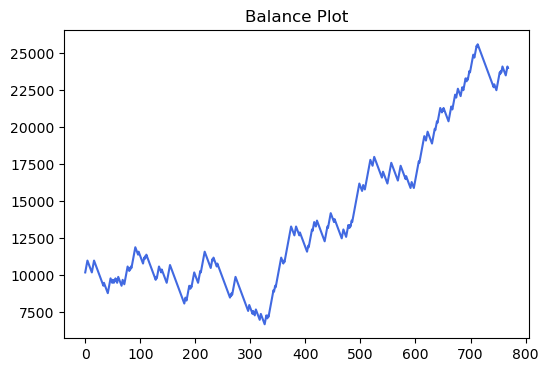

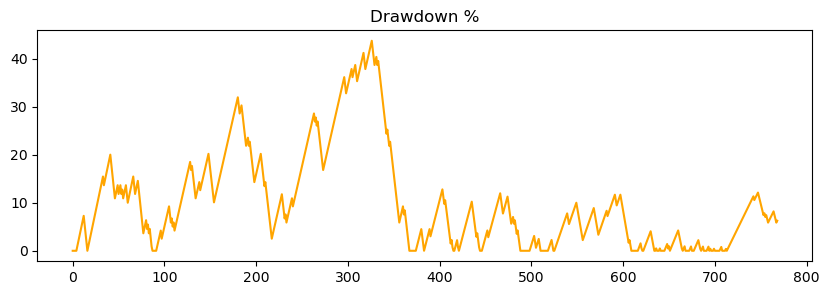

<Figure size 600x300 with 0 Axes>

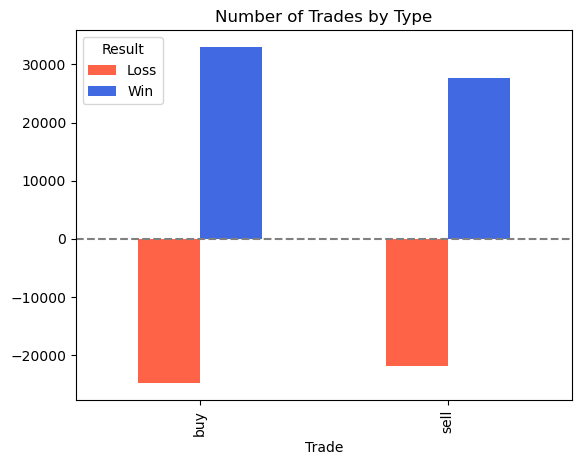

In [23]:
#----------------
# Trading Results
#----------------
a=log.groupby('Result').count()

log_1=log.drop('Entry date',axis=1)
b=log_1.groupby(['Trade','Result']).sum()
b_unstack=b['PnL'].unstack()

# Calculating the Sharpe ratio
returns=np.array(log['Returns'])
average_returns=np.mean(returns)
std_dev=np.std(returns,ddof=1)
risk_free_rate=0.016

# Computing key metrics
winrate=(100*a.iloc[1]['Trade'])/(len(log))

slpips=dtrades['Pips'].mean()

max_drawdown=max(log['Drawdown %'])

sharpe_ratio=((average_returns-risk_free_rate)/std_dev)*mth.sqrt(252)

EV=(((winrate/100)*RRR)+((1-(winrate/100))*(-1)))

Returns=((log.iloc[-1]['Final balance']-Starting_balance)/Starting_balance)*100

Profit_factor=((winrate/100)*RRR)/(1-(winrate/100))

#------------------------------------------------------------
print(a['Trade'])

print('-------------------------')
print('Number of trades: {}'.format(len(log)))
print('RRR: {}:1'.format(RRR))
print('Winrate: {} %'.format(round(winrate,2)))
print('Average SL: {} pips'.format(round(slpips,1)))
print('Max Drawdown: {} %'.format(max_drawdown))
print('Sharpe Ratio: {}'.format(round(sharpe_ratio,2)))
print('Expected Value: $ {}'.format(round(EV,3)))
print('ROI: {} %, risking {} %'.format(round(Returns,2),Risk))
print('Profit factor: {}'.format(round(Profit_factor,3)))

plt.figure(figsize=(6,4))
log['Final balance'].plot(title='Balance Plot',color='royalblue')
plt.figure(figsize=(10,3))
log['Drawdown %'].plot(title='Drawdown %',color='orange')
plt.figure(figsize=(6,3))
b_unstack[['Loss','Win']].plot(kind='bar',title='PnL of Trades by Type',color=('tomato','royalblue'))
plt.axhline(y=0,color='gray',linestyle='--')

In [24]:
# The dataframe containing every trade information
log

,Trade,Entry date,Result,Risk Amount,Profit Amount,PnL,Entry,SL,TP,Final balance,Returns,Drawdown %
0,sell,2005-05-26,Win,100.0,200.0,200.0,1.820399,1.843756,1.773686,10200.0,2.00,0.00
1,sell,2005-06-08,Win,100.0,200.0,200.0,1.824385,1.848075,1.777004,10400.0,1.96,0.00
2,sell,2005-06-20,Win,100.0,200.0,200.0,1.822589,1.846897,1.773974,10600.0,1.92,0.00
3,sell,2005-06-22,Win,100.0,200.0,200.0,1.820897,1.845653,1.771383,10800.0,1.89,0.00
4,sell,2005-06-28,Win,100.0,200.0,200.0,1.817191,1.841103,1.769366,11000.0,1.85,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
764,buy,2024-10-25,Loss,100.0,200.0,-100.0,1.297337,1.280163,1.331683,23500.0,-0.42,8.20
765,sell,2024-10-31,Win,100.0,200.0,200.0,1.295958,1.313727,1.260420,23700.0,0.85,7.42
766,sell,2024-11-07,Win,100.0,200.0,200.0,1.288328,1.308785,1.247413,23900.0,0.84,6.64
767,sell,2024-11-11,Win,100.0,200.0,200.0,1.291706,1.312494,1.250129,24100.0,0.84,5.86


## Summary
---
In this backtest, we see that the strategy experienced large drawdowns (40% Max DD) in the first half of the backtest period, and performed excellently in the second half of the backtest period. The test period provided similar amounts of trades for both bullish and bearish trades.

## Recommendations
---
1. Trading this strategy with multiple uncorrelated financial instruments in an effort to diversify can potentially produce reduced drawdowns and a better sharpe ratio.
2. Trading this strategy on an intraday timeframe can potentially produce similar results as the daily timeframe used in this backtest in a shorter period of time
3. Using filters (e.g volatility filters, volume filters, multi-timeframe analysis etc.) could be effective at increasing winrate.
4. Using a more dynamic risk management model could significantly improve returns.